# Virtual Acoustic Environments Spring 2022
## Project 9: Headphone Equalization using the Mean Square Error
**Author: Alpar Gür**

**Supervisor: David Bau**

**Professor: Christoph Pörschmann**

---

In [1]:
# import packages
import numpy as np
import sounddevice as sd
import soundfile as sf

from collections import defaultdict
from numpy import ndarray, convolve, append
from numpy.fft import fft, ifft
from scipy.signal import butter, firwin, firwin2, unit_impulse, sosfilt, kaiserord, freqz
from shared.record_signal import convert_audio_to_numpy_array, play_sound
import matplotlib.pyplot as plt

import IPython.display as ipd

In [2]:
# define global parameters
fs = 44100
n = 17640
n_one_sided = int(n / 2 + 1)
recording_count = 10
headphones = ['HD600', 'K601_001918']

Get Impulse Response (IR) for each Headphone

In [3]:
def get_impulse_response_in_time_domain(headphone: str, i: int, n: int = 17640):
    audio, fs = convert_audio_to_numpy_array(f"../HPIRs_Erbes_44100Hz/Measurements/{headphone}/pass0{i}.wav")
    return audio

In [4]:
headphone_impulse_responses = defaultdict(dict)

for i in range(len(headphones)):
    key = headphones[i]
    print(f"Headphone:\t {key}")
    for inner_key in range(recording_count):
        headphone_impulse_responses[key][inner_key] = get_impulse_response_in_time_domain(key, inner_key, n)
    shape = headphone_impulse_responses[key][recording_count-1].shape
    print(f'Shape:\t\t {shape}')

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Get Fourier Transform of IRs for each Headphone

In [5]:
def transform_impulse_responses_to_frequency_domain(recording):
    y_l = recording[:, 0]
    y_r = recording[:, 1]
    Y_L = fft(y_l)
    Y_R = fft(y_r)
    Y = append([Y_L], [Y_R], axis=0)
    Y = Y.transpose()
    return Y

In [6]:
headphone_impulse_responses_fft = defaultdict(dict)

for i in range(len(headphones)):
    key = headphones[i]
    print(f"Headphone:\t {key}")
    for inner_key in range(recording_count):
        headphone_impulse_responses_fft[key][inner_key] = transform_impulse_responses_to_frequency_domain(headphone_impulse_responses[key][inner_key])
    shape = headphone_impulse_responses_fft[key][recording_count-1].shape
    print(f'Shape:\t\t {shape}')

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Compute Complex Mean of Time Domain IRs for each Headphone

In [7]:
def get_complex_mean(audios, recording_count, n: int = 17640):
    Y_L_sum = np.empty([n])
    Y_R_sum = np.empty([n])

    for inner_key in range(recording_count):
        Y_L_sum = Y_L_sum + audios[inner_key][:, 0]
        Y_R_sum = Y_R_sum + audios[inner_key][:, 1]

    Y_L_complex_mean = Y_L_sum / recording_count
    Y_R_complex_mean = Y_R_sum / recording_count
    Y_complex_mean = append([Y_L_complex_mean], [Y_R_complex_mean], axis = 0)
    Y_complex_mean = Y_complex_mean.transpose()

    return Y_complex_mean

In [8]:
headphone_complex_means = defaultdict(dict)

for i in range(len(headphones)):
    key = headphones[i]
    print(f"Headphone:\t {key}")
    headphone_complex_means[key] = get_complex_mean(headphone_impulse_responses_fft[key], recording_count, n)
    shape = headphone_complex_means[key].shape
    print(f'Shape:\t\t {shape}')


Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Visualize Spectrum

In [26]:
def viz_spectrum(recording, n, ax1_title, ax2_title, title, fs=44100):
    f_vec = np.linspace(0, fs/2, n)
    left_channel = recording[:, 0][: n]
    right_channel = recording[:, 1][: n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)

    ax1.set_xlabel("Frequency [Hz]")
    ax2.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Magnitude (dB)")

    ax1.semilogx(f_vec, 20*np.log10(np.abs(left_channel)))
    ax2.semilogx(f_vec, 20*np.log10(np.abs(right_channel)))

    ax1.set_xlim([20, fs/2])
    ax1.set_ylim(-60, 10)
    ax2.set_xlim([20, fs/2])
    ax2.set_ylim(-60, 10)

    ax1.grid(True)
    ax2.grid(True)

    fig.suptitle(title)
    fig.show()

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_77053/3298632570.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


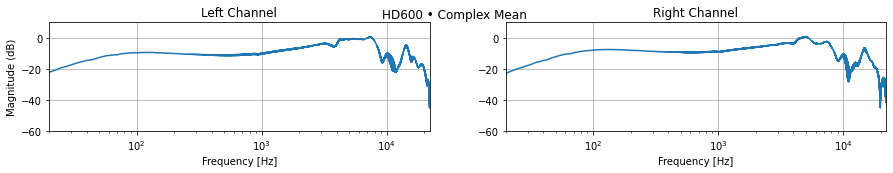

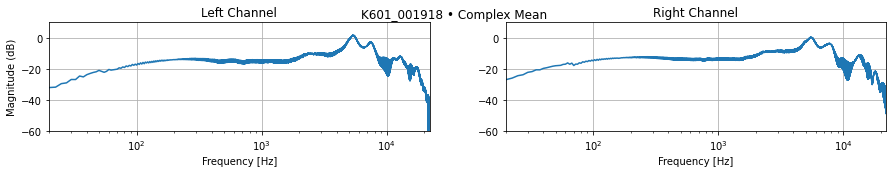

In [28]:
for headphone in headphones:
    viz_spectrum(headphone_complex_means[headphone], n_one_sided, 'Left Channel', 'Right Channel', f'{headphone} • Complex Mean')